In [22]:
%%capture

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from torchtext.vocab import build_vocab_from_iterator
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score_fn
import matplotlib.pyplot as plt
import random
import re
from collections import Counter
from tqdm import tqdm
from tqdm.notebook import tqdm
import gdown
from functools import partial

import pickle
import numpy as np
import pandas as pd
import time
import os
import sys
import spacy
import ast

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [23]:

if torch.backends.mps.is_available():
    DEVICE = 'mps'  # Apple GPU 사용
elif torch.cuda.is_available():
    DEVICE = 'cuda'  # NVIDIA GPU 사용
else:
    DEVICE = 'cpu'   # CPU fallback

print(DEVICE)

cuda


In [24]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [25]:
# data 다운
train_path = 'Cooking_Dataset/train.csv'
dev_path = 'Cooking_Dataset/dev.csv'
test_path = 'Cooking_Dataset/test.csv'


if not os.path.exists('Cooking_Dataset'):
    os.makedirs('Cooking_Dataset')
    print("Downloading Dataset") 
    gdown.download("https://drive.google.com/uc?id=1uZdYjvllt0dSdKKtrCgKHUk-APKdmeNU", train_path, quiet=False)
    gdown.download("https://drive.google.com/uc?id=1SAMbkdtjGBYgojqobiwe7ZmnEq7SiGsF", dev_path, quiet=False)
    gdown.download("https://drive.google.com/uc?id=1v6Rr2et_4WA5mRwwlRxtLhn38pbmr9Yr", test_path, quiet=False)


train_df = pd.read_csv(train_path)
#train_df = train_df.sample(n=200,random_state=42)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

# 데이터 확인
print(f"Train data size: {len(train_df)}")
print(f"Dev data size: {len(dev_df)}")
print(f"Test data size: {len(test_df)}")
print("\nTrain data sample:")
print(train_df.head())
#No-Bake Nut Cookies
# ["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken nuts (pecans)", "2 Tbsp. butter or margarine", "3 1/2 c. bite size shredded rice biscuits"]
# ["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]

Train data size: 162899
Dev data size: 1065
Test data size: 1081

Train data sample:
                      Title  \
0       No-Bake Nut Cookies   
1               Creamy Corn   
2      Reeses Cups(Candy)     
3  Cheeseburger Potato Soup   
4       Rhubarb Coffee Cake   

                                         Ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
2  ["1 c. peanut butter", "3/4 c. graham cracker ...   
3  ["6 baking potatoes", "1 lb. of extra lean gro...   
4  ["1 1/2 c. sugar", "1/2 c. butter", "1 egg", "...   

                                              Recipe  
0  ["In a heavy 2-quart saucepan, mix brown sugar...  
1  ["In a slow cooker, combine all ingredients. C...  
2  ["Combine first four ingredients and press in ...  
3  ["Wash potatoes; prick several times with a fo...  
4  ["Cream sugar and butter.", "Add egg and beat ...  


In [26]:
spacy_en = spacy.load('en_core_web_sm')

def tokenizer_ingredient_baseline(text):
    """
    Baseline 전처리: 소문자화 + lemmatization + 간단한 필터링
    - stopword 제거 있음
    - 숫자, 구두점 제거 있음
    - 불필요한 복잡 전처리 없음
    """
    import ast
    text_list = ast.literal_eval(text)
    tokens = []

    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):
        for item in text_list:
            doc = spacy_en(item.lower())
            for token in doc:
                if token.is_punct or token.like_num or token.is_stop:
                    continue
                tokens.append(token.lemma_.strip())  # 기본 lemmatization만 유지
    return tokens



def tokenizer_recipe_baseline(text):
    """
    Recipe 전처리: 소문자화 + lemmatization만 수행 (구두점, stopword, 숫자는 유지)
    - 조리 순서, 동사 등 자연스러운 문장 흐름을 보존해야 하므로 간단한 전처리만 적용
    """
    tokens = []
    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):
        doc = spacy_en(text.lower())
        for token in doc:
            # 너무 공격적인 필터링은 하지 않음
            if token.is_space:
                continue
            tokens.append(token.lemma_.strip())
    return tokens



def tokenizer_ingredient_checklist(text, remove_stopwords=True, lemmatize=True):
    text_list = ast.literal_eval(text)  # 문자열 → 리스트로 변환
    unit_keywords = {
        'c', 'cup', 'cups', 'tbsp', 'tablespoon', 'tsp', 'teaspoon',
        'oz', 'ounce', 'lb', 'pound', 'g', 'kg', 'mg',
        'pt', 'qt', 'gal', 'ml', 'l','carton','container',
        'package', 'pkg', 'envelope', 'box', 'bag', 'jar', 'can', 'cans', 'bottle',
        'dash', 'pinch', 'slice', 'slices', 'head', 'inch', 'inches',
        'stick', 'sticks', 'small', 'medium', 'large', 'size','graham'
    }

    tokens = []

    with spacy_en.select_pipes(disable=["parser", "ner"]):
        for item in text_list:
            doc = spacy_en(item.lower())
            for token in doc:
                if token.is_punct or token.is_space:
                    continue
                if token.like_num:
                    continue
                if token.text.strip(".") in unit_keywords:
                    continue
                if remove_stopwords and token.is_stop:
                    continue
                if token.pos_ in {"ADJ", "VERB", "ADV", "PRON"}:
                    continue

                tokens.append(token.lemma_.strip() if lemmatize else token.text.strip())
    

    return tokens

def tokenizer_recipe_extension(text):  # 디폴트: lemmatize 안 함
    text_list = ast.literal_eval(text)
    tokens = []

    # tagger는 유지해서 lemma 써도 warning 없음
    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):
        for item in text_list:
            doc = spacy_en(item.lower())  # 소문자화
            for token in doc:
                if token.is_punct or token.is_space:
                    continue  # 마침표, 쉼표 제거
                if token.like_num:  # 숫자 유지
                    tokens.append(token.text.strip())
                    continue
                
                tokens.append(token.text.strip())
                
    return tokens




In [27]:
ing = train_df.iloc[1,2]
print(ing)
print(tokenizer_recipe_extension(ing))

["In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated through and cheese is melted. Stir well before serving. Yields 6 servings."]
['in', 'a', 'slow', 'cooker', 'combine', 'all', 'ingredients', 'cover', 'and', 'cook', 'on', 'low', 'for', '4', 'hours', 'or', 'until', 'heated', 'through', 'and', 'cheese', 'is', 'melted', 'stir', 'well', 'before', 'serving', 'yields', '6', 'servings']


/home/psarda/repos/jkim0094-CookingRecipeGenerato/.venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [28]:
def build_vocab(token_lists, min_freq=2):
    # vocab 생성: 자주 등장하는 단어만 포함 + 특수 토큰 정의
    vocab = build_vocab_from_iterator(
        token_lists,  # 토큰 리스트들을 직접 반복
        min_freq=min_freq,  # 최소 등장 빈도
        specials=['<pad>', '<sos>', '<eos>', '<unk>']  # 특수 토큰 추가
    )
    vocab.set_default_index(vocab['<unk>'])  # 없는 단어는 <unk>로 처리
    return vocab

In [29]:
import os
import pickle
import requests
from tqdm import tqdm

def load_or_tokenize_data(model_type, train_df, config=None):
    use_checklist = config.get("USE_CHECKLIST", False)

    tokenizer_ingredient = tokenizer_ingredient_baseline
    tokenizer_recipe = tokenizer_recipe_baseline
    tokenizer_checklist = tokenizer_ingredient_checklist if use_checklist else None

    ingredient_cache_path = "tokens/ingredient_tokens.pkl"
    recipe_cache_path = "tokens/recipe_tokens.pkl"
    checklist_cache_path = "tokens/checklist_tokens.pkl"

    ingredient_cache_download = "https://drive.google.com/uc?id=1Wxvq-qy4ifbzPKmcm_VuNRRXrEOSqisJ"
    recipe_cache_download = "https://drive.google.com/uc?id=1IyBlDfL9sE8_Ip3muDyciCK9Hiv_VZF8"
    checklist_cache_download = "https://drive.google.com/uc?id=1-WVksjq8Cgj6UiJ7wtemU2CfP4hhPrci"

    if not os.path.exists('tokens'):
        os.makedirs('tokens')

    cache_targets = [
        (ingredient_cache_path, ingredient_cache_download),
        (recipe_cache_path, recipe_cache_download)
    ]
    if use_checklist:
        cache_targets.append((checklist_cache_path, checklist_cache_download))

    for path, url in cache_targets:
        if not os.path.exists(path):
            print(f"⬇️  Downloading: {path}")
            try:
                r = requests.get(url, allow_redirects=True)
                if r.status_code == 200:
                    with open(path, 'wb') as f:
                        f.write(r.content)
                    print(f"✅ Downloaded: {path}")
                else:
                    print(f"❌ Download failed for {path}")
            except Exception as e:
                print(f"❌ Download error: {e}")

    if os.path.exists(ingredient_cache_path):
        with open(ingredient_cache_path, "rb") as f:
            ingredient_token_lists = pickle.load(f)
        print("✅ Loaded ingredient token cache.")
    else:
        print("⚠️ No ingredient cache → Tokenizing...")
        ingredient_token_lists = [tokenizer_ingredient(text) for text in tqdm(train_df['Ingredients'], desc="Tokenizing ingredients")]
        with open(ingredient_cache_path, "wb") as f:
            pickle.dump(ingredient_token_lists, f)

    if os.path.exists(recipe_cache_path):
        with open(recipe_cache_path, "rb") as f:
            recipe_token_lists = pickle.load(f)
        print("✅ Loaded recipe token cache.")
    else:
        print("⚠️ No recipe cache → Tokenizing...")
        recipe_token_lists = [tokenizer_recipe(text) for text in tqdm(train_df['Recipe'], desc="Tokenizing recipes")]
        with open(recipe_cache_path, "wb") as f:
            pickle.dump(recipe_token_lists, f)

    ingredient_vocab = build_vocab(ingredient_token_lists, min_freq=1)
    recipe_vocab = build_vocab(recipe_token_lists, min_freq=2)

    checklist_vocab = None
    if use_checklist:
        if os.path.exists(checklist_cache_path):
            with open(checklist_cache_path, "rb") as f:
                checklist_token_lists = pickle.load(f)
            print("✅ Loaded checklist token cache.")
        else:
            print("⚠️ No checklist cache → Tokenizing...")
            checklist_token_lists = [tokenizer_checklist(text) for text in tqdm(train_df['Ingredients'], desc="Checklist tokenize")]
            with open(checklist_cache_path, "wb") as f:
                pickle.dump(checklist_token_lists, f)

        checklist_vocab = build_vocab(checklist_token_lists, min_freq=1)

    return ingredient_token_lists, recipe_token_lists, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe, checklist_vocab, tokenizer_checklist




In [30]:
def get_checklist_tensor(checklist_vocab, checklist_tokenizer, ingredient_texts, device, embedding_layer):
    batch_ids = []



    for text in ingredient_texts:
        tokens = checklist_tokenizer(text)
        ids = [checklist_vocab[token] for token in tokens]
        batch_ids.append(torch.tensor(ids, dtype=torch.long))

    checklist_padded = pad_sequence(batch_ids, batch_first=True, padding_value=checklist_vocab['<pad>']).to(device)
    checklist_mask = (checklist_padded != checklist_vocab['<pad>']).float().to(device)
    checklist_embeds = embedding_layer(checklist_padded)



    return checklist_embeds, checklist_mask


In [31]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe):
        self.df = df
        self.ingredient_vocab = ingredient_vocab
        self.recipe_vocab = recipe_vocab
        self.tokenizer_ingredient = tokenizer_ingredient
        self.tokenizer_recipe = tokenizer_recipe

    def __getitem__(self, idx):
        ingredient_text = self.df.iloc[idx]['Ingredients']
        recipe_text = self.df.iloc[idx]['Recipe']

        ingredient_tokens = self.tokenizer_ingredient(ingredient_text)
        recipe_tokens = self.tokenizer_recipe(recipe_text)

        ingredient_ids = [self.ingredient_vocab['<sos>']] + [self.ingredient_vocab[token] for token in ingredient_tokens] + [self.ingredient_vocab['<eos>']]
        recipe_ids = [self.recipe_vocab['<sos>']] + [self.recipe_vocab[token] for token in recipe_tokens] + [self.recipe_vocab['<eos>']]

        return torch.tensor(ingredient_ids), torch.tensor(recipe_ids), ingredient_text  # ✅ 3개 반환

    def __len__(self):
        return len(self.df)



In [32]:
def collate_fn(batch, ingredient_vocab, recipe_vocab, device):
    ingredients, recipes, ingredient_texts = zip(*batch)  # ingredient_texts: str
    ingredients_padded = pad_sequence(ingredients, batch_first=True, padding_value=ingredient_vocab['<pad>'])
    recipes_padded = pad_sequence(recipes, batch_first=True, padding_value=recipe_vocab['<pad>'])
    return ingredients_padded.to(device), recipes_padded.to(device), list(ingredient_texts)


In [33]:
class Encoder_GRU(nn.Module):
    def __init__(self, ingredient_vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio,
                 embedding_weights=None, freeze=False):
        super().__init__()
        # 임베딩
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze)
        else:
            self.embedding = nn.Embedding(ingredient_vocab_size, embedding_dim)
        

        # GRU 레이어
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          n_layers,
                          dropout=dropout_ratio if n_layers>1 else 0,
                          batch_first=True)

        # 드롭아웃
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src):
        # src : [batch_size, src_len]
        src = src.long() 
        # 임베딩
        embedded = self.dropout(self.embedding(src))
        # embedded : [batch_size, src_len, hidden_dim]

        # gru 통과
        outputs, hidden = self.gru(embedded) # h0를 따로 주지 않으면, 디폴트로 h0가 0로 초기화되서 들어감
        # outputs: [batch_size, src_len, hidden_size]
        # hidden: [n_layers, batch_size, hidden_size]

        return outputs,hidden

class Encoder_GRU_extension(nn.Module):
    def __init__(self, ingredient_vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio,
                 embedding_weights=None, freeze=False):
        super().__init__()
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze)
        else:
            self.embedding = nn.Embedding(ingredient_vocab_size, embedding_dim)
        self.ingredient_vocab_size = ingredient_vocab_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout_ratio)

        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers,
                          dropout=dropout_ratio if n_layers > 1 else 0,
                          batch_first=True)

        self.skip_proj = nn.Linear(embedding_dim, hidden_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        self._init_weights()  # ✅ 초기화 적용

    def _init_weights(self):
        # embedding 초기화 (from_pretrained 아닌 경우만)
        if not hasattr(self.embedding, 'weight') or self.embedding.weight.requires_grad:
            nn.init.kaiming_normal_(self.embedding.weight, mode='fan_in', nonlinearity='leaky_relu')

        # GRU 내부 weight 초기화
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='leaky_relu')
            elif 'bias' in name:
                nn.init.constant_(param, 0)

        # skip connection projection 초기화
        nn.init.kaiming_normal_(self.skip_proj.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(self.skip_proj.bias, 0)

    def forward(self, src):
        src = src.long()
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.gru(embedded)
        skip = self.skip_proj(embedded)
        outputs = self.leaky_relu(outputs + skip)
        outputs = self.layer_norm(outputs)
        return outputs, hidden



class Decoder_GRU(nn.Module):
    def __init__(self, recipe_vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio):
        super().__init__()

        self.recipe_vocab_size = recipe_vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        # 임베딩
        self.embedding = nn.Embedding(recipe_vocab_size, embedding_dim)

        # GRU 레이어
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          n_layers,
                          dropout=dropout_ratio if n_layers>1 else 0,
                          batch_first=True)

        # fc 레이어
        self.fc_out = nn.Linear(hidden_dim, recipe_vocab_size)

        # 드롭아웃
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, input, hidden):
        input = input.long()
        # input : [batch_size]
        input = input.unsqueeze(1)
        # input : [batch_size, 단어의 개수=1]

        # 임베딩
        embedded = self.dropout(self.embedding(input))
        # embedded : [batch_size, 단어의 개수=1, hidden_dim]

        # GRU 통과
        outputs, hidden = self.gru(embedded,hidden)
        # outputs: [batch_size, 단어의 개수=1, hidden_size]
        # hidden: [n_layers, batch_size, hidden_size]

        # fc 통과
        prediction = self.fc_out(outputs.squeeze(1))
        # prediction: [batch_size, vocab_size]

        return prediction, hidden

# Define a decoder with attention mechanism using PyTorch's nn.Module
class AttnDecoderRNN(nn.Module):
    def __init__(self, recipe_vocab_size,embedding_dim, hidden_size, n_layers, dropout_ratio):
        # Initialize the base nn.Module class
        super(AttnDecoderRNN, self).__init__()

        # Save parameters
        self.recipe_vocab_size = recipe_vocab_size              # Size of the output vocabulary
        self.embedding_dim = embedding_dim                  # Dropout probability
        self.hidden_size = hidden_size              # Size of the hidden state in GRU
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio
                  

        # Define layers
        self.embedding = nn.Embedding(self.recipe_vocab_size, self.hidden_size)  # Converts word indices to dense vectors
        self.dropout = nn.Dropout(self.dropout_ratio)                          # Applies dropout for regularization
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, self.n_layers, dropout=self.dropout_ratio if self.n_layers>1 else 0, batch_first=True)
             # GRU to process the embedded inputs
        self.out = nn.Linear(self.hidden_size * 2, self.recipe_vocab_size)       # Linear layer for generating final output

    def forward(self, input, hidden, encoder_outputs):
        input = input.long() 
        # input : [batch_size]
        input = input.unsqueeze(1)
        # input : [batch_size, 단어의 개수=1]

        # 임베딩
        embedded = self.dropout(self.embedding(input))
        # embedded : [batch_size, 단어의 개수=1, hidden_dim]

        # Pass through GRU
        output, hidden = self.gru(embedded, hidden)  # output: [batch, 1, hidden_size]

        # Compute attention weights using dot-product attention:
        # hidden[-1]: [batch, hidden_size]
        # encoder_outputs: [batch, src_len, hidden_size]
    
        attn_weights = F.softmax(
            torch.bmm(output, encoder_outputs.transpose(1, 2)), # [batch, 1, hidden_size] x [batch, hidden_size, src_len]
            dim=-1
        )  # [batch, 1, src_len]

        # Apply attention weights to encoder outputs to get context vector
        # attn_weights: (1, 1, max_length)
        # encoder_outputs.unsqueeze(0): (1, max_length, hidden_size)
        attn_output = torch.bmm(attn_weights, encoder_outputs)  # [batch, 1, hidden_size]

        # Concatenate attention output and decoder hidden state
        concat_output = torch.cat((output, attn_output), dim=2)  # [batch, 1, hidden*2]

        # Pass through linear layer and softmax to get output word probabilities
        output = F.log_softmax(self.out(concat_output).squeeze(1), dim=1)  # [batch, vocab_size]

        # Return output word distribution, updated hidden state, and attention weights
        return output, hidden, attn_weights.squeeze(1)

class AttnDecoderRNN_extension(nn.Module):
    def __init__(self, recipe_vocab_size, embedding_dim, hidden_size, n_layers, dropout_ratio):
        super().__init__()
        self.recipe_vocab_size = recipe_vocab_size
        self.embedding = nn.Embedding(recipe_vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.gru = nn.GRU(embedding_dim, hidden_size, n_layers,
                          dropout=dropout_ratio if n_layers > 1 else 0,
                          batch_first=True)
        self.out = nn.Linear(hidden_size * 2, recipe_vocab_size)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.layer_norm = nn.LayerNorm(hidden_size)

        self._init_weights()  # ✅ He 초기화 호출

    def _init_weights(self):
        # Embedding
        nn.init.kaiming_normal_(self.embedding.weight, mode='fan_in', nonlinearity='leaky_relu')

        # GRU weights & biases
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='leaky_relu')
            elif 'bias' in name:
                nn.init.constant_(param, 0)

        # Linear layer
        nn.init.kaiming_normal_(self.out.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(self.out.bias, 0)

    def forward(self, input, hidden, encoder_outputs):
        input = input.long().unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded, hidden)
        output = self.leaky_relu(output)
        output = self.layer_norm(output)

        attn_weights = F.softmax(torch.bmm(output, encoder_outputs.transpose(1, 2)), dim=-1)
        context = torch.bmm(attn_weights, encoder_outputs)
        concat_output = torch.cat((output, context), dim=2)
        output = F.log_softmax(self.out(concat_output).squeeze(1), dim=1)
        return output, hidden, attn_weights.squeeze(1)

class DecoderWithChecklistCopy(nn.Module):
    def __init__(self, recipe_vocab_size, embedding_dim, hidden_size, n_layers, dropout_ratio,
                 checklist_vocab_size, checklist_vocab, tokenizer_checklist,
                 use_checklist=True, use_copy=False):
        super().__init__()
        self.recipe_vocab_size = recipe_vocab_size
        self.embedding = nn.Embedding(recipe_vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.gru = nn.GRU(embedding_dim, hidden_size, n_layers,
                          dropout=dropout_ratio if n_layers > 1 else 0,
                          batch_first=True)

        self.out_proj = nn.Linear(hidden_size, recipe_vocab_size)
        self.attn_proj = nn.Linear(hidden_size, hidden_size)  # for both checklist & encoder attention
        self.ref_selector = nn.Linear(hidden_size, 3)

        self.use_checklist = use_checklist
        self.use_copy = use_copy

        # Checklist
        if self.use_checklist:
            self.checklist_embedding = nn.Embedding(checklist_vocab_size, hidden_size)
            self.checklist_max_len = checklist_vocab_size
            self.checklist_vocab = checklist_vocab
            self.tokenizer_checklist = tokenizer_checklist
            self.a_prev_list = []

        # Copy
        if self.use_copy:
            self.copy_attn = nn.Linear(hidden_size, hidden_size)
            self.copy_score = nn.Linear(hidden_size, 1)  # to compute p_gen

    def forward(self, input_token, hidden, encoder_outputs=None,
                ingredient_texts=None, a_prev=None, checklist_embeds=None,
                checklist_mask=None, encoder_input_ids=None, **kwargs):

        input_token = input_token.unsqueeze(1)
        embedded = self.dropout(self.embedding(input_token))
        gru_out, hidden = self.gru(embedded, hidden)
        h_t = gru_out.squeeze(1)  # [batch, hidden_dim]

        # === Checklist ===
        if self.use_checklist and ingredient_texts is not None and a_prev is not None:
            batch_ids = []
            for text in ingredient_texts:
                tokens = self.tokenizer_checklist(text)
                ids = [self.checklist_vocab[token] for token in tokens]
                batch_ids.append(torch.tensor(ids, dtype=torch.long))
            padded = pad_sequence(batch_ids, batch_first=True, padding_value=0)
            checklist_embeds = self.checklist_embedding(padded.to(input_token.device))
            checklist_mask = (padded != 0).float().to(input_token.device)

            used_mask = a_prev.clamp(0, 1).unsqueeze(2)
            unused_mask = (1 - a_prev).clamp(0, 1).unsqueeze(2)
            E_new = checklist_embeds * unused_mask
            E_used = checklist_embeds * used_mask

            h_proj = self.attn_proj(h_t).unsqueeze(2)
            scores_new = torch.bmm(E_new, h_proj).squeeze(2)
            scores_used = torch.bmm(E_used, h_proj).squeeze(2)

            scores_new = scores_new.masked_fill(checklist_mask == 0, -1e9)
            scores_used = scores_used.masked_fill(checklist_mask == 0, -1e9)

            alpha_new = F.softmax(scores_new, dim=1)
            alpha_used = F.softmax(scores_used, dim=1)

            c_new = torch.bmm(alpha_new.unsqueeze(1), checklist_embeds).squeeze(1)
            c_used = torch.bmm(alpha_used.unsqueeze(1), checklist_embeds).squeeze(1)
        else:
            alpha_new = alpha_used = None
            c_new = c_used = torch.zeros_like(h_t)

        # === Copy ===
        if self.use_copy and encoder_outputs is not None:
            attn_scores = torch.bmm(encoder_outputs, h_t.unsqueeze(2)).squeeze(2)
            attn_weights = F.softmax(attn_scores, dim=1)
            context_vector = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
            # p_gen gate
            p_gen_input = torch.cat([h_t, context_vector], dim=1)
            p_gen = torch.sigmoid(self.copy_score(p_gen_input))
        else:
            context_vector = torch.zeros_like(h_t)
            p_gen = torch.ones((h_t.size(0), 1), device=h_t.device)

        # === Output ===
        f_logits = self.ref_selector(h_t)
        f = F.softmax(f_logits, dim=-1)
        f_gru, f_new, f_used = f.chunk(3, dim=1)

        o_t = f_gru * h_t + f_new * c_new + f_used * c_used + context_vector
        output = self.out_proj(o_t)

        # === Coverage update ===
        if self.use_checklist and self.training:
            if not hasattr(self, "a_prev_list"):
                self.a_prev_list = []
            self.a_prev_list.append((a_prev.detach(), alpha_new.detach()))

        a_t = a_prev + f_new * alpha_new if self.use_checklist else None
        return output, hidden, a_t, alpha_new, alpha_used


class IngredientAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder, vocab_size):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.vocab_size = vocab_size

    def forward(self, src):
        encoder_outputs, hidden = self.encoder(src)
        input_token = src[:, 0]  # <sos>
        outputs = torch.zeros(src.size(0), src.size(1) - 1, self.vocab_size).to(src.device)

        for t in range(1, src.size(1)):
            output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
            outputs[:, t-1, :] = output
            input_token = src[:, t]  # teacher forcing

        return outputs


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, use_attention, recipe_vocab):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.use_attention = use_attention
        self.recipe_vocab = recipe_vocab

    def forward(self, src, ingredient_texts=None, target=None,
                teacher_forcing_ratio=0.5, max_len=50):
        
        encoder_outputs, hidden = self.encoder(src)
        batch_size = src.size(0)
        vocab_size = self.decoder.recipe_vocab_size

        # ✅ Decoder 기능 판단
        use_checklist = getattr(self.decoder, 'use_checklist', False)
        use_copy = getattr(self.decoder, 'use_copy', False)

        # ✅ Checklist 준비
        checklist_embed, checklist_mask = None, None
        if use_checklist:
            checklist_embed, checklist_mask = get_checklist_tensor(
                checklist_vocab=self.decoder.checklist_vocab,
                checklist_tokenizer=self.decoder.tokenizer_checklist,
                ingredient_texts=ingredient_texts,
                device=self.device,
                embedding_layer=self.decoder.checklist_embedding
            )

        a_prev = None
        if checklist_mask is not None:
            checklist_len = checklist_mask.size(1)
            a_prev = torch.zeros(batch_size, checklist_len, device=self.device)

        # ▶️ Inference Mode
        if target is None:
            outputs = []
            input_token = torch.tensor([self.recipe_vocab['<sos>']] * batch_size).to(self.device).long()

            for _ in range(max_len):
                if use_checklist or use_copy:
                    output, hidden, a_prev, *_ = self.decoder(
                        input_token, hidden, encoder_outputs,
                        ingredient_texts=ingredient_texts,
                        a_prev=a_prev,
                        checklist_embeds=checklist_embed,
                        checklist_mask=checklist_mask,
                        encoder_input_ids=src
                    )
                elif self.use_attention:
                    result = self.decoder(input_token, hidden, encoder_outputs)
                    output, hidden = result[:2] if isinstance(result, (tuple, list)) else result
                else:
                    output, hidden = self.decoder(input_token, hidden)

                top1 = output.argmax(1)
                outputs.append(top1.unsqueeze(1))
                input_token = top1

            return torch.cat(outputs, dim=1)

        # 🟢 Training Mode
        target = target.long()
        target_len = target.shape[1]
        outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
        input_token = target[:, 0].long()

        for t in range(1, target_len):
            if use_checklist or use_copy:
                output, hidden, a_prev, *_ = self.decoder(
                    input_token, hidden, encoder_outputs,
                    ingredient_texts=ingredient_texts,
                    a_prev=a_prev,
                    checklist_embeds=checklist_embed,
                    checklist_mask=checklist_mask,
                    encoder_input_ids=src
                )
            elif self.use_attention:
                result = self.decoder(input_token, hidden, encoder_outputs)
                output, hidden = result[:2] if isinstance(result, (tuple, list)) else result
            else:
                output, hidden = self.decoder(input_token, hidden)

            outputs[:, t, :] = output
            top1 = output.argmax(1)
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input_token = target[:, t] if teacher_force else top1

        return outputs



In [34]:
def get_encoder_decoder(model_type, config, input_dim, output_dim, embedding_weights=None, freeze_embedding=False, checklist_vocab=None, tokenizer_checklist=None):
    use_attention = config["USE_ATTENTION"]
    is_extension = "extension" in model_type

    if is_extension:
        encoder = Encoder_GRU_extension(
            ingredient_vocab_size=input_dim,
            embedding_dim=config["EMBED_DIM"],
            hidden_dim=config["HIDDEN_DIM"],
            n_layers=config["N_LAYERS"],
            dropout_ratio=config["DROPOUT"],
            embedding_weights=embedding_weights,
            freeze=freeze_embedding
        )
        if config.get("USE_CHECKLIST", False):
            decoder = DecoderWithChecklistCopy(
                recipe_vocab_size=output_dim,
                embedding_dim=config["EMBED_DIM"],
                hidden_size=config["HIDDEN_DIM"],
                n_layers=config["N_LAYERS"],
                dropout_ratio=config["DROPOUT"],
                checklist_vocab_size=len(checklist_vocab),
                checklist_vocab=checklist_vocab,
                tokenizer_checklist=tokenizer_checklist
            )
        else:
            decoder = AttnDecoderRNN_extension(
                recipe_vocab_size=output_dim,
                embedding_dim=config["EMBED_DIM"],
                hidden_size=config["HIDDEN_DIM"],
                n_layers=config["N_LAYERS"],
                dropout_ratio=config["DROPOUT"]
            )
    else:
        encoder = Encoder_GRU(
            ingredient_vocab_size=input_dim,
            embedding_dim=config["EMBED_DIM"],
            hidden_dim=config["HIDDEN_DIM"],
            n_layers=config["N_LAYERS"],
            dropout_ratio=config["DROPOUT"],
            embedding_weights=embedding_weights,
            freeze=freeze_embedding
        )
        if use_attention:
            decoder = AttnDecoderRNN(
                recipe_vocab_size=output_dim,
                embedding_dim=config["EMBED_DIM"],
                hidden_size=config["HIDDEN_DIM"],
                n_layers=config["N_LAYERS"],
                dropout_ratio=config["DROPOUT"]
            )
        else:
            decoder = Decoder_GRU(
                recipe_vocab_size=output_dim,
                embedding_dim=config["EMBED_DIM"],
                hidden_dim=config["HIDDEN_DIM"],
                n_layers=config["N_LAYERS"],
                dropout_ratio=config["DROPOUT"]
            )

    return encoder, decoder

In [35]:
def build_glove_embedding_matrix(glove_path, vocab, glove_dim=200):
    print("🔎 Loading GloVe vectors...")
    glove_embeddings = {}

    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = torch.tensor(list(map(float, values[1:])))
            glove_embeddings[word] = vector

    # Initialize matrix with random vectors
    embedding_matrix = torch.randn(len(vocab), glove_dim)

    for word, idx in vocab.get_stoi().items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]

    print("✅ GloVe embedding matrix created.")
    return embedding_matrix


In [36]:
def loss_epoch(model, dataloader, criterion, optimizer=None,
               teacher_forcing_ratio=0.5, max_len=50,
               USE_PENALTY=False, penalty_lambda=0.2):
    total_loss = 0
    batch_losses = []

    if hasattr(model.decoder, "a_prev_list"):
        model.decoder.a_prev_list = []

    for i, (src_batch, trg_batch, ingredient_texts) in enumerate(dataloader):
        src_batch = src_batch.to(DEVICE)
        trg_batch = trg_batch.to(DEVICE)

        output = model(src_batch, ingredient_texts, trg_batch,
                       teacher_forcing_ratio=teacher_forcing_ratio,
                       max_len=max_len)

        output_dim = output.shape[-1]
        output = output[:, 1:, :].reshape(-1, output_dim)
        trg = trg_batch[:, 1:].reshape(-1)

        loss = criterion(output, trg)

        if USE_PENALTY and hasattr(model.decoder, 'a_prev_list'):
            penalty = 0.0
            for a_prev, alpha_new in model.decoder.a_prev_list:
                penalty += torch.sum(torch.min(a_prev, alpha_new))
            penalty = penalty / src_batch.size(0)
            loss += penalty_lambda * penalty

        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

        batch_loss = loss.item() * src_batch.shape[0]
        batch_losses.append(batch_loss)
        total_loss += batch_loss
        print(f"Batch {i+1}/{len(dataloader)} | Loss: {loss.item():.4f}")

    epoch_loss = total_loss / len(dataloader.dataset)
    return epoch_loss, batch_losses


def Train(model, train_loader, val_loader, criterion, optimizer, recipe_vocab,
          EPOCHS, BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path, TEACHER_FORCING_RATIO, MAX_LEN, **kwargs):

    lr_step = kwargs.get("LR_STEP")
    lr_gamma = kwargs.get("LR_GAMMA")
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_gamma) if lr_step and lr_gamma else None

    USE_PENALTY = kwargs.get("USE_PENALTY", False)
    PENALTY_LAMBDA = kwargs.get("PENALTY_LAMBDA", 0.2)

    loss_history = {"train_epoch": [], "train_iter": [], "val_epoch": []}
    best_val_loss = float('inf')
    train_start_time = time.time()
    best_epoch = -1
    best_train_loss = None

    for ep in range(EPOCHS):
        ep_start_time = time.time()
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"[Epoch: {ep+1}/{EPOCHS}] current_LR = {current_lr}")

        model.train()
        train_epoch_loss, train_batch_loss = loss_epoch(
            model, train_loader, criterion, optimizer,
            teacher_forcing_ratio=TEACHER_FORCING_RATIO,
            max_len=MAX_LEN,
            USE_PENALTY=USE_PENALTY,
            penalty_lambda=PENALTY_LAMBDA
        )
        loss_history["train_epoch"].append(train_epoch_loss)
        loss_history["train_iter"].append(train_batch_loss)
        print(f"{ep+1} Epoch Train Completed!")

        print("Validation Start!")
        model.eval()
        with torch.no_grad():
            val_loss, _ = loss_epoch(
                model, val_loader, criterion, optimizer=None,
                teacher_forcing_ratio=0.0,
                max_len=MAX_LEN,
                USE_PENALTY=USE_PENALTY,
                penalty_lambda=PENALTY_LAMBDA
            )
            loss_history["val_epoch"].append(val_loss)
        print("Validation Completed!")

        ep_elapsed_time = time.time() - ep_start_time
        print("-" * 50)
        print(f"[Epoch {ep+1}/{EPOCHS}] ")
        print(f"Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {ep_elapsed_time:.2f}s")
        bleu, meteor, bert_f1 = compute_metrics(model, val_loader, recipe_vocab, max_len=MAX_LEN)
        print(f"Validation Metrics:")
        print(f"📊 BLEU: {bleu:.4f} | METEOR: {meteor:.4f} | BERTScore-F1: {bert_f1:.4f}")  
        print("-" * 50)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = ep+1
            best_train_loss = train_epoch_loss
            best_bleu, best_meteor, best_bert_f1 = bleu, meteor, bert_f1
            os.makedirs("results", exist_ok=True)
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": ep+1,
                "val_loss": val_loss,
                "train_loss": train_epoch_loss,
            }, save_model_path)
            print("Best model saved!")

        if scheduler is not None:
            scheduler.step()

    final_model_path = save_model_path.replace(".pt", "_final.pt")
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": EPOCHS,
        "val_loss": val_loss,
        "train_loss": train_epoch_loss,
    }, final_model_path)
    print("Final model saved!")

    train_elapsed_time = time.time() - train_start_time
    total_iterations = sum(len(batch_list) for batch_list in loss_history["train_iter"])
    torch.save({
        "loss_history": loss_history,
        "EPOCHS": EPOCHS,
        "BATCH_SIZE": BATCH_SIZE,   
        "TRAIN_RATIO": TRAIN_RATIO,
        "train_elapsed_time": train_elapsed_time,
        "total_iterations": total_iterations,
        "LR_STEP": kwargs.get("LR_STEP"),
        "LR_GAMMA": kwargs.get("LR_GAMMA")
    }, save_history_path)
    print("Training Completed!")
    print(f"Total number of iteration : {total_iterations}")
    print(f"Total Time for Training: {train_elapsed_time:.2f}s")

    print("\n======= Training Summary =======")
    print(f"Best Model:    Epoch {best_epoch}")
    if best_epoch == EPOCHS:
        print(f"(Best model is the final model)")
    print(f"Train Loss:    {best_train_loss:.4f}")
    print(f"Val Loss:      {best_val_loss:.4f}")
    print(f"BLEU:          {best_bleu:.4f}")
    print(f"METEOR:        {best_meteor:.4f}")
    print(f"BERTScore-F1:  {best_bert_f1:.4f}")
    print("\n")
    print(f"Final Model:   Epoch {EPOCHS}")
    print(f"Train Loss:    {train_epoch_loss:.4f}")
    print(f"Val Loss:      {val_loss:.4f}")
    print(f"BLEU:          {bleu:.4f}")
    print(f"METEOR:        {meteor:.4f}")
    print(f"BERTScore-F1:  {bert_f1:.4f}")
    print(f"Total Time:     {train_elapsed_time:.2f}s")
    print("==================================\n")
    return loss_history

def train_autoencoder(model, dataloader, criterion, optimizer, epochs, device, label="AutoEncoder"):
    model.train()
    for ep in range(epochs):
        total_loss = 0
        for src_batch, _, _ in tqdm(dataloader, desc=f"Epoch {ep+1}/{epochs}"):
            src_batch = src_batch.to(device)
            output = model(src_batch)
            trg = src_batch[:, 1:].contiguous()

            output = output.view(-1, output.size(-1))
            trg = trg.view(-1)

            loss = criterion(output, trg)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"[Epoch {ep+1}/{epochs}] {label} Loss: {avg_loss:.4f}")



def Test(model, test_loader, criterion, recipe_vocab, MAX_LEN,
         USE_PENALTY=False, penalty_lambda=0.2):
    model.eval()

    with torch.no_grad():
        test_loss, _ = loss_epoch(
            model,
            test_loader,
            criterion,
            optimizer=None,
            teacher_forcing_ratio=0.0,
            max_len=MAX_LEN,
            USE_PENALTY=USE_PENALTY,
            penalty_lambda=penalty_lambda
        )

    # 평가 지표 계산
    bleu_score, meteor_avg, bertscore_f1 = compute_metrics(model, test_loader, recipe_vocab)

    print(f"Test Loss      : {test_loss:.4f}")
    print(f"BLEU-4 Score   : {bleu_score:.4f}")
    print(f"METEOR Score   : {meteor_avg:.4f}")
    print(f"BERTScore (F1) : {bertscore_f1:.4f}")

    return test_loss, bleu_score, meteor_avg, bertscore_f1




def compute_metrics(model, dataloader, recipe_vocab, max_len=50):
    """
    테스트셋 전체에서 BLEU, METEOR, BERTScore 계산

    Returns:
        bleu_score (float), meteor_avg (float), bertscore_f1 (float)
    """
    model.eval()
    smoothie = SmoothingFunction().method4

    ref_list = []
    hyp_list = []

    with torch.no_grad():
        for src_batch, trg_batch, ingredient_texts in tqdm(dataloader, desc="Evaluating Metrics"):

            src_batch = src_batch.to(DEVICE)
            trg_batch = trg_batch.to(DEVICE)

            generated = model(src_batch, target=None, teacher_forcing_ratio=0.0, max_len=max_len)

            for i in range(src_batch.size(0)):
                pred_tokens = generated[i].tolist()
                trg_tokens = trg_batch[i].tolist()

                # <eos> 기준으로 자르기
                if recipe_vocab['<eos>'] in pred_tokens:
                    pred_tokens = pred_tokens[:pred_tokens.index(recipe_vocab['<eos>'])]
                if recipe_vocab['<eos>'] in trg_tokens:
                    trg_tokens = trg_tokens[:trg_tokens.index(recipe_vocab['<eos>'])]

                pred_words = [recipe_vocab.get_itos()[idx] for idx in pred_tokens]
                trg_words = [recipe_vocab.get_itos()[idx] for idx in trg_tokens]

                ref_list.append(trg_words)
                hyp_list.append(pred_words)

    # BLEU-4
    bleu_score = corpus_bleu([[ref] for ref in ref_list], hyp_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) 

    # METEOR
    meteor_scores = [meteor_score([ref], hyp) for ref, hyp in zip(ref_list, hyp_list)]
    meteor_avg = sum(meteor_scores) / len(meteor_scores)

    # BERTScore
    refs = [" ".join(ref) for ref in ref_list]
    hyps = [" ".join(hyp) for hyp in hyp_list]
    _, _, f1 = bert_score_fn(hyps, refs, lang='en', verbose=False)
    bertscore_f1 = f1.mean().item()

    return bleu_score, meteor_avg, bertscore_f1


def plot_loss_epoch(name, loss_history):
    plt.figure(figsize=(6, 3))

    train_loss = loss_history["train_epoch"]
    val_loss = loss_history["val_epoch"]

    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train Loss", color="blue")
    plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation Loss", color="red")

    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel("Loss", fontsize=10)
    plt.title(f"Loss per Epoch: {name}", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




In [37]:
def main(model_type: str, config: dict,
         train_df, dev_df, test_df,
         glove_path: str = "./glove.6B.200d.txt"):

    # 1. Tokenize & Vocab
    ingredient_token_lists, recipe_token_lists, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe, checklist_vocab, tokenizer_checklist = load_or_tokenize_data(model_type, train_df, config)

    # 2. GloVe 임베딩 적용 여부
    embedding_weights = None
    freeze_embedding = config.get("freeze_embedding", False)
    if config.get("use_glove", False):
        print(f"🔎 Using GloVe embeddings for {model_type}")
        ingredient_embedding_matrix = build_glove_embedding_matrix(
            glove_path, ingredient_vocab, glove_dim=config["EMBED_DIM"]
        )
        embedding_weights = ingredient_embedding_matrix

    # 3. Dataset & DataLoader
    BATCH_SIZE = config.get("BATCH_SIZE", 64)
    train_dataset = CustomDataset(train_df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe)
    dev_dataset = CustomDataset(dev_df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe)
    test_dataset = CustomDataset(test_df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe)
    collate = partial(collate_fn, ingredient_vocab=ingredient_vocab, recipe_vocab=recipe_vocab, device=DEVICE)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
    train_loader_autoencoder= DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)

    # ✅ 4. AutoEncoder 사전학습 여부에 따라 사전학습 실행 (ingredient_vocab 사용)
    if config.get("USE_AUTOENCODER", False):
        encoder_path = f"results/{model_type}_encoder_pretrained.pt"
        if os.path.exists(encoder_path):
            print(f"AutoEncoder encoder weights already exist for {model_type}")
            pass
        else:
            print(f"📦 AutoEncoder pretraining required for {model_type}")
            MakingAutoEncoder(
                model_type=model_type,
                config=config,
                input_vocab=ingredient_vocab,
                train_loader=train_loader_autoencoder,
                embedding_weights=embedding_weights,
                freeze_embedding=freeze_embedding,
                device=DEVICE
            )

    # 5. Model 구성 (recipe_vocab 사용)
    INPUT_DIM = len(ingredient_vocab)
    OUTPUT_DIM = len(recipe_vocab)
    criterion = nn.CrossEntropyLoss(ignore_index=recipe_vocab['<pad>'])

    encoder, decoder = get_encoder_decoder(
        model_type=model_type,
        config=config,
        input_dim=INPUT_DIM,
        output_dim=OUTPUT_DIM,
        embedding_weights=embedding_weights,
        freeze_embedding=freeze_embedding,
        checklist_vocab=checklist_vocab,
        tokenizer_checklist=tokenizer_checklist
    )

    # ✅ 6. 사전학습된 AutoEncoder 인코더 가중치만 로드
    if config.get("USE_AUTOENCODER", False):
        encoder_path = f"results/{model_type}_encoder_pretrained.pt"
        print(f"🔁 Loading pretrained AutoEncoder encoder weights for {model_type}")
        encoder.load_state_dict(torch.load(encoder_path, map_location=DEVICE))

    model = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"], recipe_vocab=recipe_vocab).to(DEVICE)

    # 7. 학습 또는 로드
    save_model_path = f"results/{model_type}.pt"
    save_history_path = f"results/{model_type}_history.pt"

    if config["new_model_train"]:
        print(f"Training model: {model_type}")
        print(model)
        optimizer = optim.Adam(model.parameters(), lr=config["LR"])
        loss_history = Train(
            model=model,
            train_loader=train_loader,
            val_loader=dev_loader,
            criterion=criterion,
            optimizer=optimizer,
            recipe_vocab=recipe_vocab,
            EPOCHS=config["EPOCHS"],
            BATCH_SIZE=BATCH_SIZE,
            TRAIN_RATIO=1.0,
            save_model_path=save_model_path,
            save_history_path=save_history_path,
            TEACHER_FORCING_RATIO=config["TEACHER_FORCING_RATIO"],
            MAX_LEN=config["MAX_LEN"],
            LR_STEP=config.get("LR_STEP"),
            LR_GAMMA=config.get("LR_GAMMA"),
            USE_PENALTY=config.get("USE_PENALTY", False),
            PENALTY_LAMBDA=config.get("PENALTY_LAMBDA", 0.2)
        )
        return model, encoder, decoder, loss_history, save_model_path, save_history_path, test_loader, recipe_vocab, ingredient_vocab

    else:
        return model, encoder, decoder, None, save_model_path, save_history_path, test_loader, recipe_vocab, ingredient_vocab




In [38]:
# 하이퍼파라미터 저장
experiment_configs = {
    "baseline1": {
        "new_model_train" : False,
        "EMBED_DIM": 128,
        "HIDDEN_DIM": 256,
        "DROPOUT": 0.5,
        "N_LAYERS": 1,
        "LR": 0.001,
        "EPOCHS": 5,
        "USE_ATTENTION": False,
        "TEACHER_FORCING_RATIO": 0.5,
        "MAX_LEN": 50,
        "BATCH_SIZE": 64
    },
    "baseline2": {
        "new_model_train" : False,
        "EMBED_DIM": 128,
        "HIDDEN_DIM": 256,
        "DROPOUT": 0.5,
        "N_LAYERS": 1,
        "LR": 0.001,
        "EPOCHS": 5,
        "USE_ATTENTION": True,
        "TEACHER_FORCING_RATIO": 0.5,
        "MAX_LEN": 50,
        "BATCH_SIZE": 64
    },
    "mild_extension1": {
        "new_model_train" : True,
        "EMBED_DIM": 200,
        "HIDDEN_DIM": 512,
        "DROPOUT": 0.5,
        "N_LAYERS": 2,
        "LR": 0.001,
        "EPOCHS": 5,
        "USE_ATTENTION": True,
        "TEACHER_FORCING_RATIO": 0.7,
        "use_glove": True,
        "freeze_embedding": False,
        "MAX_LEN": 100,
        "LR_STEP": 1,         
        "LR_GAMMA": 0.7,
        "BATCH_SIZE": 64,
        "USE_AUTOENCODER": True,
        "AUTOENCODER_EPOCHS": 5,
    },
    "mild_extension2": {
        "new_model_train" : True,
        "EMBED_DIM": 200,  # GloVe 6B 200D와 일치
        "HIDDEN_DIM": 512,
        "DROPOUT": 0.5,
        "N_LAYERS": 2,
        "LR": 0.001,
        "EPOCHS": 5,
        "USE_ATTENTION": True,
        "TEACHER_FORCING_RATIO": 0.7,
        "MAX_LEN": 100,
        "LR_STEP": 1,         
        "LR_GAMMA": 0.7,
        "use_glove": True,   
        "freeze_embedding": False,
        "BATCH_SIZE": 64,
        #"USE_AUTOENCODER": True,
        #"AUTOENCODER_EPOCHS": 10,
    },
    "spicy_extension1": {
    "new_model_train": False,
    "EMBED_DIM": 256,
    "HIDDEN_DIM": 512,
    "DROPOUT": 0.5,
    "N_LAYERS": 3,
    "LR": 0.001,
    "EPOCHS": 2,
    "USE_ATTENTION": True,
    "TEACHER_FORCING_RATIO": 0.5,
    "MAX_LEN": 100,
    "LR_STEP": 1,
    "LR_GAMMA": 0.7,
    "BATCH_SIZE": 64,
    "USE_CHECKLIST": True,       # checklist 메커니즘
    "USE_PENALTY": True,         # coverage loss 사용
    "PENALTY_LAMBDA": 0.2        # coverage loss 가중치
},
"spicy_extension2": {
    "new_model_train": False,
    "EMBED_DIM": 256,
    "HIDDEN_DIM": 512,
    "DROPOUT": 0.5,
    "N_LAYERS": 2,
    "LR": 0.001,
    "EPOCHS": 2,
    "USE_ATTENTION": True,
    "TEACHER_FORCING_RATIO": 0.5,
    "MAX_LEN": 100,
    "LR_STEP": 1,
    "LR_GAMMA": 0.7,
    "BATCH_SIZE": 64,
    "USE_CHECKLIST": True,   # checklist attention
    "USE_COPY": True         # copy mechanism
}

}

In [39]:
def MakingAutoEncoder(model_type, config, input_vocab, train_loader,
                      embedding_weights=None, freeze_embedding=False,device=DEVICE):

    os.makedirs("results", exist_ok=True)

    INPUT_DIM = len(input_vocab)

    # 1. Encoder / Decoder 준비 (입력 = 출력)
    encoder, decoder = get_encoder_decoder(
        model_type=model_type,
        config=config,
        input_dim=INPUT_DIM,
        output_dim=INPUT_DIM,
        embedding_weights=embedding_weights,
        freeze_embedding=freeze_embedding
    )

    # 2. AutoEncoder 구성
    autoencoder = IngredientAutoEncoder(encoder, decoder, vocab_size=INPUT_DIM).to(device)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=config.get("LR", 0.001))
    criterion = nn.CrossEntropyLoss(ignore_index=input_vocab['<pad>'])

    # 3. 학습
    print(f"🚀 Pretraining AutoEncoder for {model_type}")
    train_autoencoder(autoencoder, train_loader, criterion, optimizer,
                      epochs=config.get("AUTOENCODER_EPOCHS", 5), device=device)

    # 4. 저장
    torch.save(encoder.state_dict(), f"results/{model_type}_encoder_pretrained.pt")
    torch.save(decoder.state_dict(), f"results/{model_type}_decoder_pretrained.pt")
    print(f"✅ Saved pretrained encoder/decoder for {model_type}")


In [40]:
def load_trained_model(model_type: str, config: dict, device=DEVICE):
    """
    best model과 final model을 모두 불러옵니다.

    Args:
        model_type (str): 저장 파일 이름 결정에 사용되는 모델 이름
        config (dict): 설정 정보 (input_dim, output_dim, attention 등 포함)
        device (torch.device): 모델을 로드할 디바이스

    Returns:
        best_model (nn.Module)
        final_model (nn.Module)
        loss_history (dict)
        best_checkpoint (dict)
        final_checkpoint (dict)
    """
    # 경로 구성
    best_model_path = f"results/{model_type}.pt"
    final_model_path = best_model_path.replace(".pt", "_final.pt")
    save_history_path = f"results/{model_type}_history.pt"

    INPUT_DIM = config["input_dim"]
    OUTPUT_DIM = config["output_dim"]
    embedding_weights = config.get("embedding_weights", None)
    freeze_embedding = config.get("freeze_embedding", False)
    checklist_vocab = config.get("checklist_vocab", None)
    tokenizer_checklist = config.get("tokenizer_checklist", None)
    recipe_vocab = config["recipe_vocab"]

    def build_model():
        encoder, decoder = get_encoder_decoder(
            model_type=model_type,
            config=config,
            input_dim=INPUT_DIM,
            output_dim=OUTPUT_DIM,
            embedding_weights=embedding_weights,
            freeze_embedding=freeze_embedding,
            checklist_vocab=checklist_vocab,
            tokenizer_checklist=tokenizer_checklist
        )
        return Seq2Seq(encoder, decoder, device, use_attention=config["USE_ATTENTION"], recipe_vocab=recipe_vocab).to(device)

    # ✅ Best model
    best_model = build_model()
    best_checkpoint = torch.load(best_model_path, map_location=device)
    best_model.load_state_dict(best_checkpoint["model_state_dict"])

    # ✅ Final model
    final_model = build_model()
    final_checkpoint = torch.load(final_model_path, map_location=device)
    final_model.load_state_dict(final_checkpoint["model_state_dict"])

    # ✅ 학습 이력
    history = torch.load(save_history_path, map_location=device)
    loss_history = history["loss_history"]

    print(f"📥 Loaded BEST model (Epoch {best_checkpoint['epoch']})")
    print(f"📥 Loaded FINAL model (Epoch {final_checkpoint['epoch']})")

    return best_model, final_model, loss_history, best_checkpoint, final_checkpoint


In [41]:
def summarize_and_test_model(model_type: str,
                             config: dict,
                             ingredient_vocab,
                             recipe_vocab,
                             test_loader,
                             criterion,
                             tokenizer_checklist=None,
                             checklist_vocab=None,
                             embedding_weights=None,
                             device=DEVICE):
    """
    저장된 best/final 모델을 불러와 summary, 그래프, 테스트 수행
    """

    # config에 input/output dim 등 필요한 정보 추가 (원본 손상 X)
    config = config.copy()
    config["input_dim"] = len(ingredient_vocab)
    config["output_dim"] = len(recipe_vocab)
    config["recipe_vocab"] = recipe_vocab
    config["embedding_weights"] = embedding_weights
    config["checklist_vocab"] = checklist_vocab
    config["tokenizer_checklist"] = tokenizer_checklist

    # ✅ 모델 두 개 모두 불러오기
    best_model, final_model, loss_history, best_ckpt, final_ckpt = load_trained_model(
        model_type, config, device
    )

    # ✅ 손실 곡선 시각화
    plot_loss_epoch(model_type, loss_history)

    # ✅ BEST 모델 평가
    print(f"\n========== BEST MODEL SUMMARY ({model_type}) ==========")
    print(f"Epoch:         {best_ckpt['epoch']}")
    print(f"Train Loss:    {best_ckpt['train_loss']:.4f}")
    print(f"Val Loss:      {best_ckpt['val_loss']:.4f}")
    print(f"Parameters:    {sum(p.numel() for p in best_model.parameters() if p.requires_grad):,}")

    print("\nRunning test on BEST model...")
    best_test_loss, best_bleu, best_meteor, best_bert = Test(
        best_model, test_loader, criterion, recipe_vocab, MAX_LEN=config["MAX_LEN"]
    )

    print("\n--- BEST MODEL TEST RESULTS ---")
    print(f"Test Loss    : {best_test_loss:.4f}")
    print(f"BLEU-4 Score : {best_bleu:.4f}")
    print(f"METEOR Score : {best_meteor:.4f}")
    print(f"BERTScore-F1 : {best_bert:.4f}")
    print("-" * 50)

    # ✅ FINAL 모델 평가
    print(f"\n========== FINAL MODEL SUMMARY ({model_type}) ==========")
    print(f"Epoch:         {final_ckpt['epoch']}")
    print(f"Train Loss:    {final_ckpt['train_loss']:.4f}")
    print(f"Val Loss:      {final_ckpt['val_loss']:.4f}")
    print(f"Parameters:    {sum(p.numel() for p in final_model.parameters() if p.requires_grad):,}")

    print("\nRunning test on FINAL model...")
    final_test_loss, final_bleu, final_meteor, final_bert = Test(
        final_model, test_loader, criterion, recipe_vocab, MAX_LEN=config["MAX_LEN"]
    )

    print("\n--- FINAL MODEL TEST RESULTS ---")
    print(f"Test Loss    : {final_test_loss:.4f}")
    print(f"BLEU-4 Score : {final_bleu:.4f}")
    print(f"METEOR Score : {final_meteor:.4f}")
    print(f"BERTScore-F1 : {final_bert:.4f}")
    print("-" * 50)

    return {
        "best": {
            "test_loss": best_test_loss,
            "BLEU": best_bleu,
            "METEOR": best_meteor,
            "BERTScore": best_bert,
        },
        "final": {
            "test_loss": final_test_loss,
            "BLEU": final_bleu,
            "METEOR": final_meteor,
            "BERTScore": final_bert,
        }
    }



================== 🔧 Training & Evaluating: baseline1 ==================
✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.
⚠️ Checkpoint for baseline1 not found. Skipping evaluation.


================== 🔧 Training & Evaluating: baseline2 ==================
✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.
⚠️ Checkpoint for baseline2 not found. Skipping evaluation.


================== 🔧 Training & Evaluating: mild_extension1 ==================
✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.
🔎 Using GloVe embeddings for mild_extension1
🔎 Loading GloVe vectors...
✅ GloVe embedding matrix created.
📦 AutoEncoder pretraining required for mild_extension1
🚀 Pretraining AutoEncoder for mild_extension1


Epoch 1/5:   0%|          | 0/40725 [00:00<?, ?it/s]/home/psarda/repos/jkim0094-CookingRecipeGenerato/.venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
Epoch 1/5: 100%|██████████| 40725/40725 [1:04:07<00:00, 10.58it/s]


[Epoch 1/5] AutoEncoder Loss: 0.7850


Epoch 2/5: 100%|██████████| 40725/40725 [1:03:49<00:00, 10.63it/s]


[Epoch 2/5] AutoEncoder Loss: 0.7874


Epoch 3/5: 100%|██████████| 40725/40725 [1:04:03<00:00, 10.59it/s]


[Epoch 3/5] AutoEncoder Loss: 0.6652


Epoch 4/5: 100%|██████████| 40725/40725 [1:03:58<00:00, 10.61it/s]


[Epoch 4/5] AutoEncoder Loss: 0.4340


Epoch 5/5: 100%|██████████| 40725/40725 [1:03:55<00:00, 10.62it/s]


[Epoch 5/5] AutoEncoder Loss: 0.4382
✅ Saved pretrained encoder/decoder for mild_extension1
🔁 Loading pretrained AutoEncoder encoder weights for mild_extension1
Training model: mild_extension1
Seq2Seq(
  (encoder): Encoder_GRU_extension(
    (embedding): Embedding(9032, 200)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(200, 512, num_layers=2, batch_first=True, dropout=0.5)
    (skip_proj): Linear(in_features=200, out_features=512, bias=True)
    (leaky_relu): LeakyReLU(negative_slope=0.01)
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): AttnDecoderRNN_extension(
    (embedding): Embedding(9081, 200)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(200, 512, num_layers=2, batch_first=True, dropout=0.5)
    (out): Linear(in_features=1024, out_features=9081, bias=True)
    (leaky_relu): LeakyReLU(negative_slope=0.01)
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (recipe_vocab): Vocab()
)
[Ep

Evaluating Metrics: 100%|██████████| 17/17 [03:13<00:00, 11.36s/it]


Validation Metrics:
📊 BLEU: 0.1622 | METEOR: 0.3421 | BERTScore-F1: 0.8691
--------------------------------------------------
Best model saved!
[Epoch: 2/5] current_LR = 0.0007
Batch 1/2546 | Loss: 2.7928
Batch 2/2546 | Loss: 2.8580
Batch 3/2546 | Loss: 3.0867
Batch 4/2546 | Loss: 2.8040
Batch 5/2546 | Loss: 2.6939
Batch 6/2546 | Loss: 2.7949
Batch 7/2546 | Loss: 2.8102
Batch 8/2546 | Loss: 3.0693
Batch 9/2546 | Loss: 2.6991
Batch 10/2546 | Loss: 2.8472
Batch 11/2546 | Loss: 2.7772
Batch 12/2546 | Loss: 2.4353
Batch 13/2546 | Loss: 3.0397
Batch 14/2546 | Loss: 3.2191
Batch 15/2546 | Loss: 2.8743
Batch 16/2546 | Loss: 2.8799
Batch 17/2546 | Loss: 2.6824
Batch 18/2546 | Loss: 2.8073
Batch 19/2546 | Loss: 2.7799
Batch 20/2546 | Loss: 2.8930
Batch 21/2546 | Loss: 2.9546
Batch 22/2546 | Loss: 3.0352
Batch 23/2546 | Loss: 2.8356
Batch 24/2546 | Loss: 2.7077
Batch 25/2546 | Loss: 2.9855
Batch 26/2546 | Loss: 2.7269
Batch 27/2546 | Loss: 2.6478
Batch 28/2546 | Loss: 2.6922
Batch 29/2546 | Loss

Evaluating Metrics: 100%|██████████| 17/17 [03:37<00:00, 12.81s/it]


Validation Metrics:
📊 BLEU: 0.1895 | METEOR: 0.3731 | BERTScore-F1: 0.8746
--------------------------------------------------
[Epoch: 3/5] current_LR = 0.00049
Batch 1/2546 | Loss: 2.4401
Batch 2/2546 | Loss: 2.6157
Batch 3/2546 | Loss: 2.4927
Batch 4/2546 | Loss: 2.6115
Batch 5/2546 | Loss: 2.1884
Batch 6/2546 | Loss: 2.3919
Batch 7/2546 | Loss: 2.7223
Batch 8/2546 | Loss: 2.7314
Batch 9/2546 | Loss: 2.6086
Batch 10/2546 | Loss: 2.7150
Batch 11/2546 | Loss: 2.4098
Batch 12/2546 | Loss: 2.5329
Batch 13/2546 | Loss: 2.9117
Batch 14/2546 | Loss: 2.6102
Batch 15/2546 | Loss: 2.3772
Batch 16/2546 | Loss: 2.4566
Batch 17/2546 | Loss: 2.5694
Batch 18/2546 | Loss: 2.8795
Batch 19/2546 | Loss: 2.5881
Batch 20/2546 | Loss: 2.3912
Batch 21/2546 | Loss: 2.4958
Batch 22/2546 | Loss: 2.7304
Batch 23/2546 | Loss: 2.6441
Batch 24/2546 | Loss: 2.8064
Batch 25/2546 | Loss: 2.5503
Batch 26/2546 | Loss: 2.3611
Batch 27/2546 | Loss: 2.7807
Batch 28/2546 | Loss: 2.7659
Batch 29/2546 | Loss: 2.4493
Batch 30

Evaluating Metrics: 100%|██████████| 17/17 [03:39<00:00, 12.90s/it]


Validation Metrics:
📊 BLEU: 0.1996 | METEOR: 0.3859 | BERTScore-F1: 0.8783
--------------------------------------------------
Best model saved!
[Epoch: 4/5] current_LR = 0.000343
Batch 1/2546 | Loss: 2.4353
Batch 2/2546 | Loss: 2.7661
Batch 3/2546 | Loss: 2.4798
Batch 4/2546 | Loss: 2.3860
Batch 5/2546 | Loss: 2.3325
Batch 6/2546 | Loss: 2.6839
Batch 7/2546 | Loss: 2.6850
Batch 8/2546 | Loss: 2.4251
Batch 9/2546 | Loss: 2.4005
Batch 10/2546 | Loss: 2.3123
Batch 11/2546 | Loss: 2.5637
Batch 12/2546 | Loss: 2.7237
Batch 13/2546 | Loss: 2.7101
Batch 14/2546 | Loss: 2.3787
Batch 15/2546 | Loss: 2.6166
Batch 16/2546 | Loss: 2.5430
Batch 17/2546 | Loss: 2.4670
Batch 18/2546 | Loss: 2.6601
Batch 19/2546 | Loss: 2.5802
Batch 20/2546 | Loss: 2.8921
Batch 21/2546 | Loss: 2.7589
Batch 22/2546 | Loss: 2.6352
Batch 23/2546 | Loss: 2.8802
Batch 24/2546 | Loss: 2.6548
Batch 25/2546 | Loss: 2.5456
Batch 26/2546 | Loss: 3.0761
Batch 27/2546 | Loss: 2.4163
Batch 28/2546 | Loss: 2.6296
Batch 29/2546 | Lo

Evaluating Metrics: 100%|██████████| 17/17 [03:46<00:00, 13.34s/it]


Validation Metrics:
📊 BLEU: 0.2112 | METEOR: 0.4016 | BERTScore-F1: 0.8798
--------------------------------------------------
[Epoch: 5/5] current_LR = 0.00024009999999999998
Batch 1/2546 | Loss: 2.4025
Batch 2/2546 | Loss: 2.7230
Batch 3/2546 | Loss: 2.3167
Batch 4/2546 | Loss: 2.4058
Batch 5/2546 | Loss: 2.4630
Batch 6/2546 | Loss: 2.5147
Batch 7/2546 | Loss: 2.4230
Batch 8/2546 | Loss: 2.5549
Batch 9/2546 | Loss: 2.6460
Batch 10/2546 | Loss: 2.5822
Batch 11/2546 | Loss: 2.4641
Batch 12/2546 | Loss: 2.7070
Batch 13/2546 | Loss: 2.4444
Batch 14/2546 | Loss: 2.3448
Batch 15/2546 | Loss: 2.3951
Batch 16/2546 | Loss: 2.4269
Batch 17/2546 | Loss: 2.3013
Batch 18/2546 | Loss: 2.7405
Batch 19/2546 | Loss: 2.3188
Batch 20/2546 | Loss: 2.5673
Batch 21/2546 | Loss: 2.4092
Batch 22/2546 | Loss: 2.4696
Batch 23/2546 | Loss: 2.8138
Batch 24/2546 | Loss: 2.6005
Batch 25/2546 | Loss: 2.8042
Batch 26/2546 | Loss: 2.6960
Batch 27/2546 | Loss: 2.4691
Batch 28/2546 | Loss: 2.4370
Batch 29/2546 | Loss: 

Evaluating Metrics: 100%|██████████| 17/17 [03:45<00:00, 13.27s/it]


Validation Metrics:
📊 BLEU: 0.2173 | METEOR: 0.4100 | BERTScore-F1: 0.8807
--------------------------------------------------
Final model saved!
Training Completed!
Total number of iteration : 12730
Total Time for Training: 18079.57s

======= Training Summary =======
Best Model:    Epoch 3
Train Loss:    2.6060
Val Loss:      6.2597
BLEU:          0.1996
METEOR:        0.3859
BERTScore-F1:  0.8783


Final Model:   Epoch 5
Train Loss:    2.4947
Val Loss:      6.3473
BLEU:          0.2173
METEOR:        0.4100
BERTScore-F1:  0.8807
Total Time:     18079.57s

📥 Loaded BEST model (Epoch 3)
📥 Loaded FINAL model (Epoch 5)


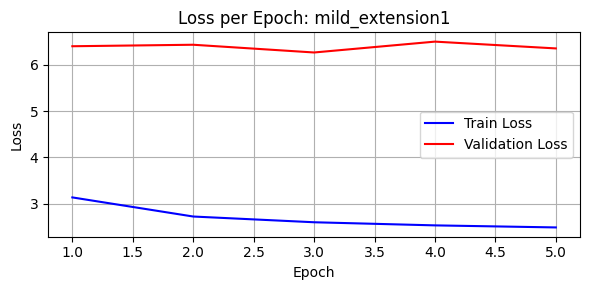


========== BEST MODEL SUMMARY (mild_extension1) ==========
Epoch:         3
Train Loss:    2.6060
Val Loss:      6.2597
Parameters:    18,380,865

Running test on BEST model...
Batch 1/17 | Loss: 6.2086
Batch 2/17 | Loss: 6.1810
Batch 3/17 | Loss: 6.1012
Batch 4/17 | Loss: 6.3128
Batch 5/17 | Loss: 6.2310
Batch 6/17 | Loss: 6.0538
Batch 7/17 | Loss: 6.2417
Batch 8/17 | Loss: 6.3132
Batch 9/17 | Loss: 6.1116
Batch 10/17 | Loss: 6.1852
Batch 11/17 | Loss: 6.4701
Batch 12/17 | Loss: 6.3512
Batch 13/17 | Loss: 6.2722
Batch 14/17 | Loss: 6.1975
Batch 15/17 | Loss: 6.4000
Batch 16/17 | Loss: 6.5224
Batch 17/17 | Loss: 6.3488


Evaluating Metrics: 100%|██████████| 17/17 [03:14<00:00, 11.47s/it]


Test Loss      : 6.2643
BLEU-4 Score   : 0.1615
METEOR Score   : 0.3233
BERTScore (F1) : 0.8768

--- BEST MODEL TEST RESULTS ---
Test Loss    : 6.2643
BLEU-4 Score : 0.1615
METEOR Score : 0.3233
BERTScore-F1 : 0.8768
--------------------------------------------------

========== FINAL MODEL SUMMARY (mild_extension1) ==========
Epoch:         5
Train Loss:    2.4947
Val Loss:      6.3473
Parameters:    18,380,865

Running test on FINAL model...
Batch 1/17 | Loss: 6.3667
Batch 2/17 | Loss: 6.2805
Batch 3/17 | Loss: 6.2240
Batch 4/17 | Loss: 6.4059
Batch 5/17 | Loss: 6.3676
Batch 6/17 | Loss: 6.1840
Batch 7/17 | Loss: 6.2509
Batch 8/17 | Loss: 6.5343
Batch 9/17 | Loss: 6.2002
Batch 10/17 | Loss: 6.2298
Batch 11/17 | Loss: 6.4139
Batch 12/17 | Loss: 6.3406
Batch 13/17 | Loss: 6.2866
Batch 14/17 | Loss: 6.1696
Batch 15/17 | Loss: 6.4108
Batch 16/17 | Loss: 6.4060
Batch 17/17 | Loss: 6.3321


Evaluating Metrics: 100%|██████████| 17/17 [03:20<00:00, 11.81s/it]


Test Loss      : 6.3178
BLEU-4 Score   : 0.1729
METEOR Score   : 0.3306
BERTScore (F1) : 0.8777

--- FINAL MODEL TEST RESULTS ---
Test Loss    : 6.3178
BLEU-4 Score : 0.1729
METEOR Score : 0.3306
BERTScore-F1 : 0.8777
--------------------------------------------------

================== 🔧 Training & Evaluating: mild_extension2 ==================
✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.
🔎 Using GloVe embeddings for mild_extension2
🔎 Loading GloVe vectors...
✅ GloVe embedding matrix created.
Training model: mild_extension2
Seq2Seq(
  (encoder): Encoder_GRU_extension(
    (embedding): Embedding(9032, 200)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(200, 512, num_layers=2, batch_first=True, dropout=0.5)
    (skip_proj): Linear(in_features=200, out_features=512, bias=True)
    (leaky_relu): LeakyReLU(negative_slope=0.01)
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): AttnDecoderRNN_extension(
    (embedding): Em

Evaluating Metrics: 100%|██████████| 17/17 [03:33<00:00, 12.54s/it]


Validation Metrics:
📊 BLEU: 0.1963 | METEOR: 0.3874 | BERTScore-F1: 0.8779
--------------------------------------------------
Best model saved!
[Epoch: 2/5] current_LR = 0.0007
Batch 1/2546 | Loss: 2.7628
Batch 2/2546 | Loss: 2.5769
Batch 3/2546 | Loss: 2.7126
Batch 4/2546 | Loss: 2.7732
Batch 5/2546 | Loss: 2.7751
Batch 6/2546 | Loss: 2.7818
Batch 7/2546 | Loss: 2.8570
Batch 8/2546 | Loss: 2.6842
Batch 9/2546 | Loss: 2.5377
Batch 10/2546 | Loss: 2.6343
Batch 11/2546 | Loss: 2.5094
Batch 12/2546 | Loss: 2.6032
Batch 13/2546 | Loss: 2.6286
Batch 14/2546 | Loss: 2.7237
Batch 15/2546 | Loss: 2.7532
Batch 16/2546 | Loss: 2.6816
Batch 17/2546 | Loss: 2.7900
Batch 18/2546 | Loss: 2.4756
Batch 19/2546 | Loss: 2.4877
Batch 20/2546 | Loss: 2.9313
Batch 21/2546 | Loss: 2.6980
Batch 22/2546 | Loss: 2.5487
Batch 23/2546 | Loss: 2.8559
Batch 24/2546 | Loss: 2.5504
Batch 25/2546 | Loss: 2.7183
Batch 26/2546 | Loss: 2.6002
Batch 27/2546 | Loss: 2.5969
Batch 28/2546 | Loss: 2.5543
Batch 29/2546 | Loss

Evaluating Metrics: 100%|██████████| 17/17 [03:40<00:00, 12.99s/it]


Validation Metrics:
📊 BLEU: 0.2180 | METEOR: 0.4053 | BERTScore-F1: 0.8804
--------------------------------------------------
Best model saved!
[Epoch: 3/5] current_LR = 0.00049
Batch 1/2546 | Loss: 2.4734
Batch 2/2546 | Loss: 2.5928
Batch 3/2546 | Loss: 2.4378
Batch 4/2546 | Loss: 2.5686
Batch 5/2546 | Loss: 2.5653
Batch 6/2546 | Loss: 2.8393
Batch 7/2546 | Loss: 2.7674
Batch 8/2546 | Loss: 2.2972
Batch 9/2546 | Loss: 2.5526
Batch 10/2546 | Loss: 2.7100
Batch 11/2546 | Loss: 2.6552
Batch 12/2546 | Loss: 2.5181
Batch 13/2546 | Loss: 2.5944
Batch 14/2546 | Loss: 2.5789
Batch 15/2546 | Loss: 2.4480
Batch 16/2546 | Loss: 2.4696
Batch 17/2546 | Loss: 2.3970
Batch 18/2546 | Loss: 2.6533
Batch 19/2546 | Loss: 2.3408
Batch 20/2546 | Loss: 2.4240
Batch 21/2546 | Loss: 2.4878
Batch 22/2546 | Loss: 2.3629
Batch 23/2546 | Loss: 2.7359
Batch 24/2546 | Loss: 2.6688
Batch 25/2546 | Loss: 2.5041
Batch 26/2546 | Loss: 2.5459
Batch 27/2546 | Loss: 2.6460
Batch 28/2546 | Loss: 2.3643
Batch 29/2546 | Los

Evaluating Metrics: 100%|██████████| 17/17 [03:40<00:00, 13.00s/it]


Validation Metrics:
📊 BLEU: 0.2145 | METEOR: 0.4038 | BERTScore-F1: 0.8812
--------------------------------------------------
Best model saved!
[Epoch: 4/5] current_LR = 0.000343
Batch 1/2546 | Loss: 2.4830
Batch 2/2546 | Loss: 2.2744
Batch 3/2546 | Loss: 2.4171
Batch 4/2546 | Loss: 2.2356
Batch 5/2546 | Loss: 2.7084
Batch 6/2546 | Loss: 2.3118
Batch 7/2546 | Loss: 2.2971
Batch 8/2546 | Loss: 2.5681
Batch 9/2546 | Loss: 2.5246
Batch 10/2546 | Loss: 2.4442
Batch 11/2546 | Loss: 2.7692
Batch 12/2546 | Loss: 2.4630
Batch 13/2546 | Loss: 2.4143
Batch 14/2546 | Loss: 2.4646
Batch 15/2546 | Loss: 2.4018
Batch 16/2546 | Loss: 2.4317
Batch 17/2546 | Loss: 2.8071
Batch 18/2546 | Loss: 2.6568
Batch 19/2546 | Loss: 2.3106
Batch 20/2546 | Loss: 2.3323
Batch 21/2546 | Loss: 2.5414
Batch 22/2546 | Loss: 2.5373
Batch 23/2546 | Loss: 2.4900
Batch 24/2546 | Loss: 2.3394
Batch 25/2546 | Loss: 2.4414
Batch 26/2546 | Loss: 2.3856
Batch 27/2546 | Loss: 2.5013
Batch 28/2546 | Loss: 2.3484
Batch 29/2546 | Lo

In [ ]:
for model_type, base_config in experiment_configs.items():
    print(f"\n================== 🔧 Training & Evaluating: {model_type} ==================")

    # ✅ config 복사 및 설정
    config = base_config.copy()

    # main 실행
    model, encoder, decoder, _, save_model_path, save_history_path, test_loader, recipe_vocab, ingredient_vocab = main(
        model_type, config, train_df, dev_df, test_df
    )

    # ✅ config에 필요한 정보 추가
    config["input_dim"] = len(ingredient_vocab)
    config["output_dim"] = len(recipe_vocab)
    config["recipe_vocab"] = recipe_vocab

    # optional: GloVe embedding이 사용되었다면 전달
    config["embedding_weights"] = config.get("embedding_weights", None)

    # optional: checklist/copy 관련 키 추가
    config["checklist_vocab"] = config.get("checklist_vocab", None)
    config["tokenizer_checklist"] = config.get("tokenizer_checklist", None)

    # 🔸 파일 존재 여부 확인
    if not os.path.exists(save_model_path) or not os.path.exists(save_history_path):
        print(f"⚠️ Checkpoint for {model_type} not found. Skipping evaluation.\n")
        continue

    # 손실 함수 정의
    criterion = nn.CrossEntropyLoss(ignore_index=recipe_vocab['<pad>'])

    # 평가 실행
    summarize_and_test_model(
        model_type=model_type,
        config=config,
        ingredient_vocab=ingredient_vocab,
        recipe_vocab=recipe_vocab,
        test_loader=test_loader,
        criterion=criterion,
        checklist_vocab=config.get("checklist_vocab"),
        tokenizer_checklist=config.get("tokenizer_checklist"),
        embedding_weights=config.get("embedding_weights")
    )


# Plot for all model

In [ ]:
# def plot_loss_iter_multi(model_list, experiment_configs, device=DEVICE):
#     plt.figure(figsize=(12, 6))
    
#     for model_type in model_list:
#         config = experiment_configs[model_type].copy()
#         ingredient_token_lists, recipe_token_lists, ingredient_vocab, recipe_vocab, tokenizer_ing, tokenizer_rec, checklist_vocab, tokenizer_checklist = \
#             load_or_tokenize_data(model_type, pd.DataFrame(), config)
    
#         config["input_dim"] = len(ingredient_vocab)
#         config["output_dim"] = len(recipe_vocab)
#         config["recipe_vocab"] = recipe_vocab

#         # 📥 모델, 기록 불러오기
#         _, _, loss_history, _, _ = load_trained_model(model_type, config, device)
#         train_iter_loss = loss_history["train_iter"]  # 리스트 of 리스트

#         # 리스트 평탄화 (iteration 기준)
#         iter_losses = [loss for epoch_losses in train_iter_loss for loss in epoch_losses]
#         plt.plot(iter_losses, label=model_type)

#     plt.title("Training Loss per Iteration")
#     plt.xlabel("Iteration")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

import numpy as np
import matplotlib.pyplot as plt

def smooth(values, window=100):
    return np.convolve(values, np.ones(window)/window, mode='valid')

def plot_loss_iter_multi(model_list, experiment_configs, device=DEVICE):
    plt.style.use("seaborn-v0_8")
    plt.figure(figsize=(12, 6))

    for model_type in model_list:
        config = experiment_configs[model_type].copy()
        ingredient_token_lists, recipe_token_lists, ingredient_vocab, recipe_vocab, tokenizer_ing, tokenizer_rec, checklist_vocab, tokenizer_checklist = \
            load_or_tokenize_data(model_type, pd.DataFrame(), config)

        config["input_dim"] = len(ingredient_vocab)
        config["output_dim"] = len(recipe_vocab)
        config["recipe_vocab"] = recipe_vocab

        _, _, loss_history, _, _ = load_trained_model(model_type, config, device)
        train_iter_loss = loss_history["train_iter"]

        iter_losses = [loss for epoch in train_iter_loss for loss in epoch]
        smoothed = smooth(iter_losses, window=100)

        plt.plot(smoothed, label=model_type, linewidth=2)

    plt.title("Smoothed Training Loss per Iteration", fontsize=14)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


In [ ]:
plot_loss_iter_multi(
    model_list=["baseline1", "baseline2"],
    experiment_configs=experiment_configs
)


✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.


FileNotFoundError: [Errno 2] No such file or directory: 'results/baseline1.pt'

<Figure size 1200x600 with 0 Axes>

# Generator

In [ ]:
def generate_recipes(sample_raw, model_names, experiment_configs):
    """
    여러 모델을 불러와 주어진 input에 대해 recipe를 생성하는 함수
    """
    # 🧾 입력을 리스트로 정리
    if isinstance(sample_raw, str):
        ingredient_list = [i.strip() for i in sample_raw.split(',')]
    elif isinstance(sample_raw, list):
        ingredient_list = sample_raw
    else:
        raise ValueError("Input must be a comma-separated string or a list.")

    print(f"🧾 Ingredients: {ingredient_list}")

    results = {}
    for model_type in model_names:
        print(f"\n🔍 Generating with model: {model_type}")
        config = experiment_configs[model_type].copy()

        # ✅ vocab, tokenizer 불러오기
        ingredient_token_lists, recipe_token_lists, ingredient_vocab, recipe_vocab, tokenizer_ing, tokenizer_rec, checklist_vocab, tokenizer_checklist = \
            load_or_tokenize_data(model_type, pd.DataFrame(), config)

        config["input_dim"] = len(ingredient_vocab)
        config["output_dim"] = len(recipe_vocab)
        config["recipe_vocab"] = recipe_vocab

        # ✅ 모델 불러오기
        _, final_model, _, _, _ = load_trained_model(model_type, config, device=DEVICE)

        # ✅ ingredient_list → 문자열로 변환 후 토크나이징
        ingredient_str = str(ingredient_list)
        tokenized = tokenizer_ing(ingredient_str)
        input_ids = torch.tensor([ingredient_vocab[token] for token in tokenized], dtype=torch.long).unsqueeze(0).to(DEVICE)

        # ✅ 예측
        final_model.eval()
        with torch.no_grad():
            prediction_ids = final_model(input_ids, ingredient_texts=[ingredient_list], target=None)

        # ✅ 디코딩
        pred_tokens = [recipe_vocab.lookup_token(tok.item()) for tok in prediction_ids[0]]
        recipe = ' '.join([
            t for t in pred_tokens 
            if t not in [ '', ',', '[', ']', '"'] # '<pad>', '<sos>', '<eos>',
        ]).strip()
        results[model_type] = recipe

    return results


In [ ]:
sample1_raw = "sugar, lemon juice,  water,  orange juice, strawberries, icecream"
sample2_raw = "8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c  lemon juice, 48 oz canned cherries, 8 inch graham cracker,  pie crusts"

# 예시 config
model_names = ["baseline1", "baseline2"]
results = generate_recipes(sample2_raw, model_names, experiment_configs)

for model, recipe in results.items():
    print(f"\n🧠 Model: {model}\n🍽️ Recipe: {recipe}")
    print("-"*50)


🧾 Ingredients: ['8 oz philadelphia cream cheese', '14 oz can sweetened condensed milk', '1 ts vanilla', '1/3 c  lemon juice', '48 oz canned cherries', '8 inch graham cracker', 'pie crusts']

🔍 Generating with model: baseline1
✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.
📥 Loaded BEST model (Epoch 4)
📥 Loaded FINAL model (Epoch 5)

🔍 Generating with model: baseline2


/Users/jeeeunkim/Desktop/FIT5217_NLP/NLP/.venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.
📥 Loaded BEST model (Epoch 3)
📥 Loaded FINAL model (Epoch 5)


/Users/jeeeunkim/Desktop/FIT5217_NLP/NLP/.venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)



🧠 Model: baseline1
🍽️ Recipe: combine first 5 ingredients in a large saucepan . stir in milk
--------------------------------------------------

🧠 Model: baseline2
🍽️ Recipe: in a large bowl combine cream cheese milk add milk and milk . beat until smooth . add in milk and beat until smooth . fold in whipped cream .
--------------------------------------------------


# Fill in the XLSX

In [ ]:
def generate_recipes_from_excel(xlsx_path, output_path, model_names, experiment_configs):
    df = pd.read_excel(xlsx_path)

    # 결과 컬럼 초기화
    for model in model_names:
        col_name = f"Recipe - {model}"
        if col_name not in df.columns:
            df[col_name] = ""

    for i, row in tqdm(df.iterrows(), total=len(df), desc="Generating Recipes"):
        try:
            ingredient_raw = row["Ingredients"]
            ingredient_list = ast.literal_eval(ingredient_raw) if isinstance(ingredient_raw, str) else ingredient_raw
            results = generate_recipes(
                sample_raw=ingredient_list,
                model_names=model_names,
                tokenizer_ingredient=None,  # 내부에서 처리
                experiment_configs=experiment_configs
            )
            for model in model_names:
                df.at[i, f"Recipe - {model}"] = results.get(model, "")
        except Exception as e:
            print(f"❌ Error at row {i}: {e}")

    df.to_excel(output_path, index=False)
    print(f"✅ Saved to {output_path}")


In [ ]:
xlsx_path = "recipes_input.xlsx"
output_path = "recipes_output.xlsx"
model_names = ["Baseline 1", "Mild Ext 1", "Spicy Ext 1"]
generate_recipes_from_excel(xlsx_path, output_path, model_names, experiment_configs)
